In [2]:
import torch
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/data/common/ethanchang/ucct/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
print("--- Setting up Model and Tokenizer with Unsloth ---")
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
max_seq_length = 2048  # Recommended to set for Unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_id,
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,
    load_in_4bit=True,
)

--- Setting up Model and Tokenizer with Unsloth ---
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.52.4.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 8. Max memory: 47.408 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [4]:
# from unsloth.chat_templates import get_chat_template
# tokenizer = get_chat_template(
#     tokenizer,
#     chat_template = "llama-3.1",
#     mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
# )
_ = FastLanguageModel.for_inference(model)

In [5]:
# --- Step 2: Prepare for Multi-Hook Capture ---
num_layers = len(model.model.layers)
all_layer_outputs = [torch.tensor(0) for _ in range(num_layers)]


def get_layer_output_hook(layer_idx):
    def hook(module, input, output):
        # print(f"--- layer: {layer_idx} ---")
        # print(f"tuple length: {len(output)}")
        # for i, o in enumerate(output):
        #     print(f"{i}th output: {o}")
        # print("\n\n")

        # many language models output a tuple that gives additional information ([hidden states, attention weights, kv cache]). We only want the first element
        all_layer_outputs[layer_idx] = output[0].detach()
        # nothing is overwritten, hook only runs once

    return hook


# Attach a hook to every decoder layer
hook_handles = []
for i in range(num_layers):
    target_layer = model.model.layers[i]
    handle = target_layer.register_forward_hook(get_layer_output_hook(i))
    hook_handles.append(handle)
print(f"Attached {len(hook_handles)} hooks to layers 0 through {num_layers - 1}.")

Attached 32 hooks to layers 0 through 31.


In [6]:
task_suite = [
    # Difficulty 1
    {
        "name": "Country to Capital (1)",
        "instruction": "What is the capital of the following country: France -> ?",
        "examples": [
            "Japan -> Tokyo",
            "Germany -> Berlin",
            "Canada -> Ottawa",
        ],
    },
    # {
    #     "name": "Simple Addition (1)",
    #     "instruction": "Calculate the sum of these two numbers: 3 + 6 -> ?",
    #     "examples": [
    #         "5 + 8 -> 13",
    #         "10 + 4 -> 14",
    #         "7 + 2 -> 9",
    #     ],
    # },
    # {
    #     "name": "Base 10 Arithmetic - Addition (1)",
    #     "instruction": "Add the two numbers in base 10: 14 + 7 -> ?",
    #     "examples": [
    #         "5 + 9 -> 14",
    #         "12 + 8 -> 20",
    #         "3 + 11 -> 14",
    #     ],
    # },
    # {
    #     "name": "Base 10 Arithmetic - Subtraction (1)",
    #     "instruction": "Subtract the second number from the first in base 10: 14 - 7 -> ?",
    #     "examples": [
    #         "9 - 5 -> 4",
    #         "12 - 4 -> 8",
    #         "10 - 6 -> 4",
    #     ],
    # },

    # # Difficulty 2
    # {
    #     "name": "English to French Translation (2)",
    #     "instruction": "Translate the following from English to French: are you my friend -> ?",
    #     "examples": [
    #         "the cat is black -> le chat est noir",
    #         "the dog is white -> le chien est blanc",
    #         "I love science -> j'aime la science",
    #     ],
    # },
    # {
    #     "name": "Base 10 Arithmetic - Multiplication (2)",
    #     "instruction": "Multiply the two numbers in base 10: 3 x 7 -> ?",
    #     "examples": [
    #         "5 x 2 -> 10",
    #         "6 x 3 -> 18",
    #         "4 x 4 -> 16",
    #     ],
    # },
    # {
    #     "name": "Synonym Matching (2)",
    #     "instruction": "Find a synonym for the given word: happy -> ?",
    #     "examples": [
    #         "fast -> quick",
    #         "sad -> unhappy",
    #         "angry -> mad",
    #     ],
    # },

    # # Difficulty 3
    # {
    #     "name": "Unscramble Words (3)",
    #     "instruction": "Unscramble the following letters to form a word: clinep -> ?",
    #     "examples": [
    #         "uptcmore -> computer",
    #         "nbaaan -> banana",
    #         "ephsatrome -> atmosphere",
    #     ],
    # },
    # {
    #     "name": "Base 10 Arithmetic - Modulo (3)",
    #     "instruction": "Compute the remainder of the first number divided by the second in base 10: 14 % 5 -> ?",
    #     "examples": [
    #         "10 % 3 -> 1",
    #         "9 % 2 -> 1",
    #         "8 % 4 -> 0",
    #     ],
    # },

    # # Difficulty 4
    # {
    #     "name": "Base 9 Arithmetic - Addition (4)",
    #     "instruction": "Add the two numbers in base 9 and return the result in base 9: 7 + 5 -> ?",
    #     "examples": [
    #         "3 + 4 -> 7",
    #         "5 + 2 -> 7",
    #         "6 + 3 -> 10",
    #     ],
    # },
    # {
    #     "name": "Base 9 Arithmetic - Subtraction (4)",
    #     "instruction": "Subtract the second number from the first in base 9 and return the result in base 9: 8 - 5 -> ?",
    #     "examples": [
    #         "6 - 2 -> 4",
    #         "7 - 3 -> 4",
    #         "5 - 5 -> 0",
    #     ],
    # },
    # {
    #     "name": "Base 8 Arithmetic - Addition (4)",
    #     "instruction": "Add the two numbers in base 8 and return the result in base 8: 6 + 3 -> ?",
    #     "examples": [
    #         "5 + 2 -> 7",
    #         "7 + 1 -> 10",
    #         "4 + 3 -> 7",
    #     ],
    # },
    # {
    #     "name": "Base 8 Arithmetic - Subtraction (4)",
    #     "instruction": "Subtract the second number from the first in base 8 and return the result in base 8: 7 - 3 -> ?",
    #     "examples": [
    #         "6 - 2 -> 4",
    #         "5 - 1 -> 4",
    #         "7 - 7 -> 0",
    #     ],
    # },

    # # Difficulty 5
    # {
    #     "name": "minus -> plus (5)",
    #     "instruction": "Find the solution based on the pattern: 10 - 4 -> ?",
    #     "examples": [
    #         "3 - 2 -> 5",
    #         "8 - 5 -> 13",
    #         "3 - 6 -> 9",
    #     ],
    # },
    # {
    #     "name": "Base 9 Arithmetic - Multiplication (5)",
    #     "instruction": "Multiply the two numbers in base 9 and return the result in base 9: 3 x 4 -> ?",
    #     "examples": [
    #         "2 x 3 -> 6",
    #         "4 x 2 -> 8",
    #         "3 x 3 -> 11",
    #     ],
    # },
    # {
    #     "name": "Base 9 Arithmetic - Modulo (5)",
    #     "instruction": "Compute the remainder of the first number divided by the second in base 9 and return it in base 9: 8 % 3 -> ?",
    #     "examples": [
    #         "7 % 2 -> 1",
    #         "6 % 4 -> 2",
    #         "5 % 5 -> 0",
    #     ],
    # },
    # {
    #     "name": "Base 8 Arithmetic - Multiplication (5)",
    #     "instruction": "Multiply the two numbers in base 8 and return the result in base 8: 3 x 3 -> ?",
    #     "examples": [
    #         "2 x 2 -> 4",
    #         "4 x 2 -> 10",
    #         "3 x 3 -> 11",
    #     ],
    # },
    # {
    #     "name": "Base 8 Arithmetic - Modulo (5)",
    #     "instruction": "Compute the remainder of the first number divided by the second in base 8 and return it in base 8: 7 % 3 -> ?",
    #     "examples": [
    #         "6 % 4 -> 2",
    #         "5 % 2 -> 1",
    #         "4 % 4 -> 0",
    #     ],
    # },

    # # Difficulty 6
    # {
    #     "name": "Pattern Induction (6)",
    #     "instruction": "Find the next number in the sequence: 2, 4, 8, 16, ? ->",
    #     "examples": [
    #         "1, 3, 5, 7 -> 9",
    #         "3, 6, 12, 24 -> 48",
    #     ],
    # },
    # {
    #     "name": "Prime Factor Decomposition (6)",
    #     "instruction": "List the prime factors of 84 -> ?",
    #     "examples": [
    #         "4 -> 2, 2",
    #         "12 -> 2, 2, 3",
    #         "35 -> 7, 5",
    #     ],
    # },

    # # Difficulty 7
    # {
    #     "name": "Symbol Substitution Puzzle (7)",
    #     "instruction": "If ♦ = 2, ♣ = 3, and ♥ = 4, what is the value of ♦ + ♣ x ♥ -> ?",
    #     "examples": [
    #         "If ♦ = 2, ♣ = 3, ♥ = 7, ♦ - ♣ x ♥ -> -7",
    #         "If ♠ = 10, ♣ = 5, ♥ = 2, ♠ / ♣ x ♥ -> 4",
    #     ],
    # },

    # # Difficulty 8
    # {
    #     "name": "Logic Deduction (8)",
    #     "instruction": "If all bloops are razzles and some razzles are jinks, can we conclude that some bloops are jinks?",
    #     "examples": [
    #         "All apples are fruits. Some fruits are yellow. -> Cannot conclude some apples are yellow.",
    #         "All mammals are animals. Some animals are fast. -> Cannot conclude some mammals are fast.",
    #     ],
    # },
    # {
    #     "name": "Anagram Logic Puzzle (8)",
    #     "instruction": "Find the correct word that is an anagram of 'rescue' and also a synonym for 'secure' -> ?",
    #     "examples": [
    #         "listen -> silent",
    #         "rescue -> secure",
    #     ],
    # },

    # # Difficulty 9
    # {
    #     "name": "Word Math (9)",
    #     "instruction": "Replace each letter with a unique digit so the equation holds: SEND + MORE = MONEY -> ?",
    #     "examples": [
    #         "SEND + MORE = MONEY -> 9567 + 1085 = 10652",
    #     ],
    # },

    # # Difficulty 10
    # {
    #     "name": "Tower of Hanoi (10)",
    #     "instruction": "How many moves are required to solve a 5-disk Tower of Hanoi puzzle? -> ?",
    #     "examples": [
    #         "1 disk -> 1",
    #         "2 disks -> 3",
    #         "3 disks -> 7",
    #         "4 disks -> 15",
    #     ],
    # },
]

In [7]:
from typing import NamedTuple


class Task(NamedTuple):
    name: str = ""
    input_header: str = "<|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\nToday Date: 26 July 2024\n\n<|eot_id|><|start_header_id|>human<|end_header_id|>\n\n"
    task: str = ""
    eot: str = "<|eot_id|>\n\nExamples:\n"
    examples: str = ""
    input_footer: str = "\n\n<|start_header_id|>assistant<|end_header_id|>\n\n"


# formats to llama-3.1 template
def formatTasks(suite: list[dict[str, str | list[str]]]) -> list[Task]:
    tasks = []
    for t in suite:
        tasks.append(
            Task(
                name=str(t["name"]),
                task=str(t["instruction"]),
                examples="\n".join(t["examples"]),
            ),
        )

    return tasks


class Range(NamedTuple):
    lower: int
    upper: int


class Input(NamedTuple):
    task_indices: Range
    examples_indices: Range
    tokenized: list[int]


def processTaskInput(task: Task) -> Input:
    lengths = []
    recon_tokens = []  # reconstructed tokens list
    for i, x in enumerate(task[1:]):
        section_tokens = tokenizer.encode(x)[
            0 if i == 0 else 1 :
        ]  # remove each begin_of_text token except first one
        recon_tokens.extend(section_tokens)
        lengths.append(len(section_tokens))

    indices = []
    lower = 0
    for length in lengths:
        indices.append(Range(lower, length + lower))
        lower += length
    print(indices)
    # input_arr = [input_header, task, "<|eot_id|>", examples, input_footer]
    return Input(
        task_indices=indices[1],
        examples_indices=indices[3],
        tokenized=recon_tokens,
    )


tasks = formatTasks(task_suite)
processedTasks: list[tuple[Task, Input]] = []
for task in tasks:
    processedTasks.append((task, processTaskInput(task)))


[Range(lower=0, upper=40), Range(lower=40, upper=52), Range(lower=52, upper=56), Range(lower=56, upper=67), Range(lower=67, upper=72)]


In [8]:
from transformers import TextStreamer  # type: ignore

task_outputs: dict[str, list[torch.Tensor]] = {}
text_streamer = TextStreamer(tokenizer)
tasks = formatTasks(task_suite)

print(f"{'=' * 10} GENERATING {'=' * 10}")
for task, input in processedTasks:
    print(f"\n\n{'-' * 10} {task.name} {'-' * 10}\n")
    _ = model.generate(
        input_ids=torch.tensor([input.tokenized]).to("cuda"),
        streamer=text_streamer,
        max_new_tokens=256,
        use_cache=True,
    )
    task_outputs[task.name] = all_layer_outputs.copy()

========== GENERATING ==========


---------- Country to Capital (1) ----------



The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

Today Date: 26 July 2024

<|eot_id|><|start_header_id|>human<|end_header_id|>

What is the capital of the following country: France ->?<|eot_id|>

Examples:
Japan -> Tokyo
Germany -> Berlin
Canada -> Ottawa

<|start_header_id|>assistant<|end_header_id|>

The answer is Paris.<|eot_id|>


In [9]:
def pairwise_cosine_distance(vectors):
    """
    Calculates the mean pairwise cosine distance for a set of vectors.
    Args:
        vectors: A tensor of shape [N, D] where N is the number of vectors
                 and D is the embedding dimension.
    Returns:
        A single scalar value for the mean pairwise cosine distance.
    """
    if vectors.shape[0] < 2:
        return torch.tensor(0.0, device=vectors.device)

    # Normalize each vector to unit length
    normalized_vectors = torch.nn.functional.normalize(vectors, p=2, dim=1, eps=1e-12)

    # Compute the cosine similarity matrix by matrix-multiplying the normalized vectors
    # Resulting shape: [N, N]
    similarity_matrix = torch.matmul(normalized_vectors, normalized_vectors.T)

    # Cosine distance is 1 - similarity
    distance_matrix = 1 - similarity_matrix

    # We only want the unique pairwise distances, which are in the upper
    # triangle of the matrix (excluding the diagonal).
    # Get the indices of the upper triangle
    upper_triangle_indices = torch.triu_indices(
        distance_matrix.shape[0], distance_matrix.shape[1], offset=1
    )

    # Extract the values and calculate the mean
    pairwise_distances = distance_matrix[
        upper_triangle_indices[0], upper_triangle_indices[1]
    ]

    return torch.mean(pairwise_distances)


class HiddenStatesByLayer(NamedTuple):
    rho_d: list[float]
    d_r: list[float]
    task_vecs: list[torch.Tensor]
    example_vecs: list[torch.Tensor]


hidden_states_by_task: dict[str, HiddenStatesByLayer] = {}

for task, input in processedTasks:
    rho_d_by_layer: list[float] = []
    d_r_by_layer: list[float] = []
    task_vecs_by_layer: list[torch.Tensor] = []
    example_vecs_by_layer: list[torch.Tensor] = []

    for i in range(num_layers):
        layer_hidden_states = all_layer_outputs[i]

        lower, upper = input.task_indices
        task_vecs = layer_hidden_states[0, lower:upper, :]
        lower, upper = input.examples_indices
        example_vecs = layer_hidden_states[0, lower:upper, :]
        # print(task_vecs.shape)
        # print(example_vecs.shape)
        task_vecs_by_layer.append(task_vecs)
        example_vecs_by_layer.append(example_vecs)

        # Calculate Pattern Density (rho_d)
        if len(example_vecs) > 1:
            # example_vecs = example_vecs.to(torch.float32)
            mean_cos_dist = pairwise_cosine_distance(example_vecs)
            rho_d = 1 / (mean_cos_dist + 1e-6)
        else:
            print(
                "WARNING: example token size 1. If this is what you want, ignore this message."
            )
            rho_d = torch.tensor(0)
        rho_d_by_layer.append(rho_d.item())

        # Calculate Representational Mismatch (d_r)
        pattern_centroid = torch.mean(example_vecs, dim=0)
        # print(pattern_centroid.shape)
        # print()
        task_centroid = torch.mean(task_vecs, dim=0)
        d_r = 1 - torch.nn.functional.cosine_similarity(
            task_centroid, pattern_centroid, dim=0
        )
        d_r_by_layer.append(d_r.item())

    hidden_states_by_task[task.name] = HiddenStatesByLayer(
        rho_d_by_layer, d_r_by_layer, task_vecs_by_layer, example_vecs_by_layer
    )

In [10]:
hidden_states_by_task

{'Country to Capital (1)': HiddenStatesByLayer(rho_d=[1.5, 1.5625, 1.609375, 1.6640625, 1.6875, 1.6953125, 1.75, 1.6953125, 1.6875, 1.75, 1.78125, 1.765625, 1.828125, 1.8671875, 1.7890625, 1.8125, 1.96875, 1.953125, 2.03125, 2.03125, 1.9375, 1.953125, 2.03125, 2.109375, 2.09375, 2.0625, 2.15625, 2.15625, 2.28125, 2.21875, 2.203125, 2.140625], d_r=[0.3046875, 0.3671875, 0.36328125, 0.41015625, 0.3828125, 0.3984375, 0.390625, 0.41796875, 0.40234375, 0.36328125, 0.390625, 0.3984375, 0.390625, 0.36328125, 0.359375, 0.33203125, 0.30859375, 0.3046875, 0.265625, 0.27734375, 0.28125, 0.2734375, 0.24609375, 0.21875, 0.21875, 0.22265625, 0.1953125, 0.19140625, 0.1796875, 0.17578125, 0.19140625, 0.328125], task_vecs=[tensor([[ 0.0356,  0.0170,  0.0115,  ...,  0.0150,  0.0181,  0.0280],
         [ 0.0173,  0.0092,  0.0110,  ...,  0.0135, -0.0008,  0.0105],
         [ 0.0084, -0.0037,  0.0095,  ..., -0.0135, -0.0053,  0.0098],
         ...,
         [-0.0067, -0.0190, -0.0030,  ..., -0.0186, -0.018

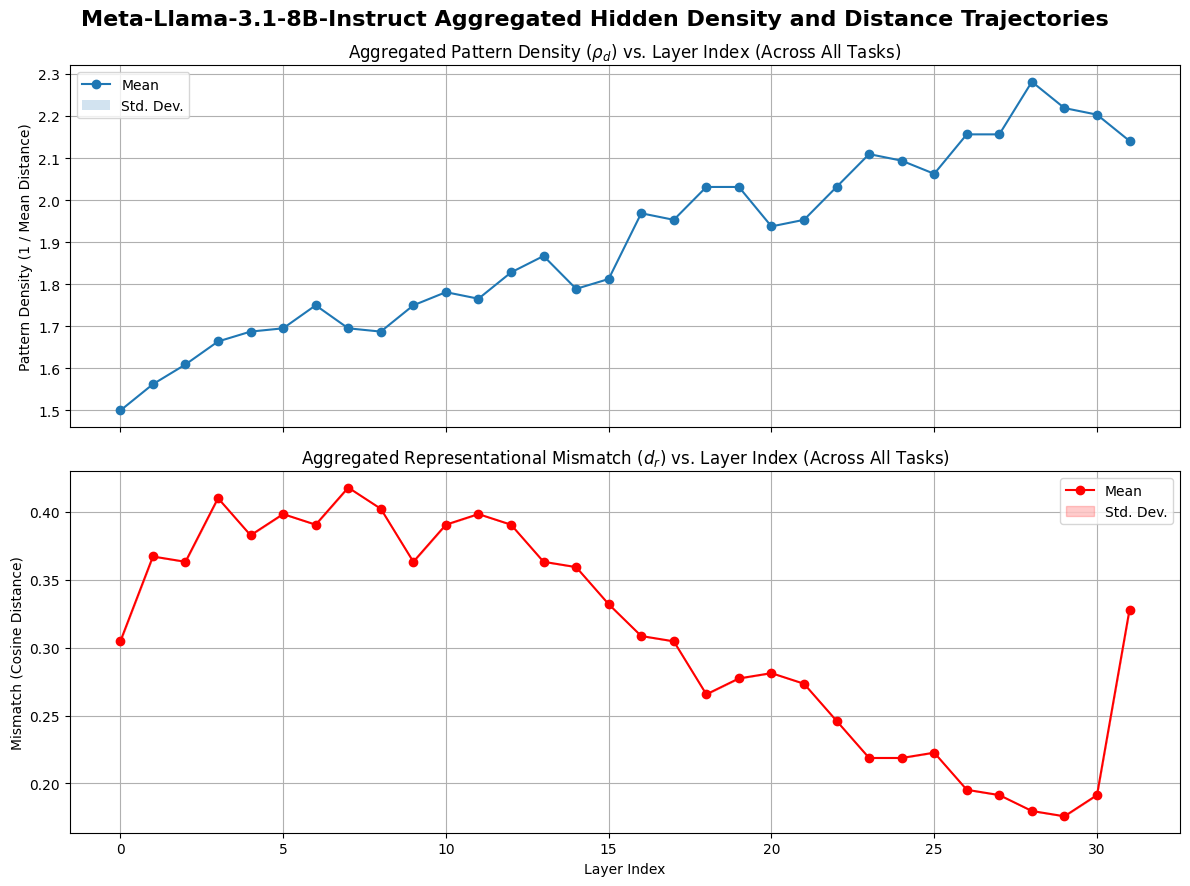


Generating overlayed plots for all tasks...


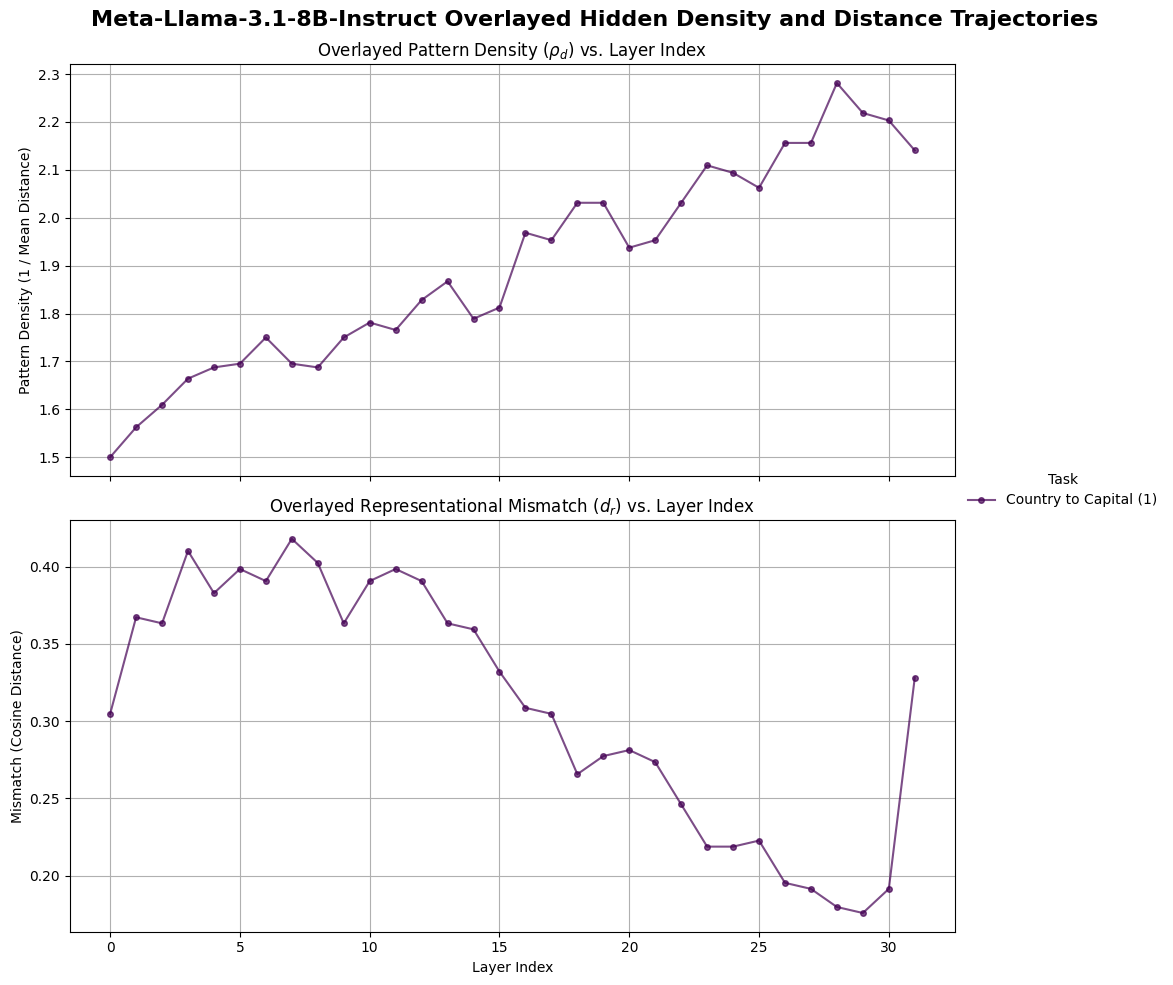

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get the data for this task
# layer_indices = list(range(num_layers))
# rho_d_values = rho_d_by_layer
# d_r_values = d_r_by_layer


# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# # Plot Pattern Density for this task
# ax1.plot(
#     layer_indices, rho_d_values, marker="o", markersize=4, linestyle="-", alpha=0.7
# )

# # Plot Representational Mismatch for this task
# ax2.plot(layer_indices, d_r_values, marker="o", markersize=4, linestyle="-", alpha=0.7)

# # --- Configure the plots ---

# # Configure Plot 1: Pattern Density
# ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index")
# ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
# ax1.legend(loc="upper right")
# ax1.grid(True)
# # Set a log scale for better visibility if early values are very high
# # ax1.set_yscale('log')
# ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index (Log Scale)")


# # Configure Plot 2: Representational Mismatch
# ax2.set_title("Overlayed Representational Mismatch ($d_r$) vs. Layer Index")
# ax2.set_ylabel("Mismatch (Cosine Distance)")
# ax2.set_xlabel("Layer Index")
# ax2.legend(loc="upper left")
# ax2.grid(True)

# # Show the plot
# plt.tight_layout()
# plt.show()


all_rho_d = np.array([res.rho_d for res in hidden_states_by_task.values()])
all_d_r = np.array([res.d_r for res in hidden_states_by_task.values()])

# Calculate mean and standard deviation across tasks for each layer
mean_rho_d = np.mean(all_rho_d, axis=0)
std_rho_d = np.std(all_rho_d, axis=0)

mean_d_r = np.mean(all_d_r, axis=0)
std_d_r = np.std(all_d_r, axis=0)

# # Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
layer_indices = list(range(num_layers))

# print(len(layer_indices))
# print(len(mean_rho_d))
# # Plot Aggregated Pattern Density
ax1.plot(layer_indices, mean_rho_d, marker="o", linestyle="-", label="Mean")
ax1.fill_between(
    layer_indices,
    mean_rho_d - std_rho_d,
    mean_rho_d + std_rho_d,
    alpha=0.2,
    label="Std. Dev.",
)
ax1.set_title(
    "Aggregated Pattern Density ($\\rho_d$) vs. Layer Index (Across All Tasks)"
)
ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
ax1.legend()
ax1.grid(True)

# # Plot Aggregated Representational Mismatch
ax2.plot(layer_indices, mean_d_r, marker="o", linestyle="-", color="r", label="Mean")
ax2.fill_between(
    layer_indices,
    mean_d_r - std_d_r,
    mean_d_r + std_d_r,
    color="r",
    alpha=0.2,
    label="Std. Dev.",
)
ax2.set_title(
    "Aggregated Representational Mismatch ($d_r$) vs. Layer Index (Across All Tasks)"
)
ax2.set_ylabel("Mismatch (Cosine Distance)")
ax2.set_xlabel("Layer Index")
ax2.legend()
ax2.grid(True)
fig.suptitle(f"{model_id.split("/")[1]} Aggregated Hidden Density and Distance Trajectories", fontsize=16, fontweight='bold')


plt.tight_layout()
plt.show()

print("\nGenerating overlayed plots for all tasks...")

# Create the plot figure
# Create the plot figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
layer_indices = list(range(num_layers))

# Use a colormap to get distinct colors for each task
colors = plt.cm.viridis(np.linspace(0, 1, len(tasks)))  # type: ignore

# Collect handles for legend
legend_handles = []

# Loop through each stored task result and plot it
for i, (task_name, results) in enumerate(hidden_states_by_task.items()):
    # Get the data for this task
    rho_d_values = results.rho_d
    d_r_values = results.d_r

    # Plot Pattern Density
    line1, = ax1.plot(
        layer_indices,
        rho_d_values,
        marker="o",
        markersize=4,
        linestyle="-",
        alpha=0.7,
        color=colors[i],
        label=task_name,
    )

    # Plot Representational Mismatch
    ax2.plot(
        layer_indices,
        d_r_values,
        marker="o",
        markersize=4,
        linestyle="-",
        alpha=0.7,
        color=colors[i],
    )

    # Save one handle for the legend
    legend_handles.append(line1)

# Configure Plot 1
ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index")
ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
ax1.grid(True)

# Configure Plot 2
ax2.set_title("Overlayed Representational Mismatch ($d_r$) vs. Layer Index")
ax2.set_ylabel("Mismatch (Cosine Distance)")
ax2.set_xlabel("Layer Index")
ax2.grid(True)

# Shared legend outside the figure
fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(.8, 0.5), title="Task", frameon=False)
# fig.legend(handles=legend_handles, loc="center left", bbox_to_anchor=(1.0, 0.5), title="Task", frameon=False)
fig.suptitle(f"{model_id.split("/")[1]} Overlayed Hidden Density and Distance Trajectories", fontsize=16, fontweight='bold')
# Adjust layout to make room for legend
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


# Next step

In [ ]:
from sklearn.decomposition import PCA
from adjustText import adjust_text


def visualize_pca_trajectory(
    hidden_states_by_task: dict[str, HiddenStatesByLayer],
    task_name: str,
    layers_to_show: list[int],
    title: str = "PCA Trajectory of Centroids",
):
    """
    Visualizes the movement of task and example centroids across layers using PCA.

    Args:
        hidden_states_by_task: The main dictionary containing the analysis results.
        task_name: The name of the specific task to visualize.
        layers_to_show: A list of layer indices to include as "snapshots".
        title: The title for the plot.
    """
    print(f"\n--- Generating PCA Trajectory Visualization for '{task_name}' ---")

    task_data = hidden_states_by_task.get(task_name)
    if not task_data:
        print(f"Error: Task '{task_name}' not found in hidden states data.")
        return

    # --- 1. Collect all centroid vectors to fit PCA on ---
    all_vectors_for_pca = []
    for layer_idx in layers_to_show:
        # Recalculate centroids for the specific layers we are showing
        task_centroid = torch.mean(task_data.task_vecs[layer_idx], dim=0)
        example_centroid = torch.mean(task_data.example_vecs[layer_idx], dim=0)
        all_vectors_for_pca.extend([task_centroid, example_centroid])

    # Convert to a single numpy array for PCA
    all_vectors_for_pca_np = (
        torch.stack(all_vectors_for_pca).to(torch.float32).cpu().numpy()
    )

    # --- 2. Fit PCA and report explained variance ---
    pca = PCA(n_components=2)
    pca.fit(all_vectors_for_pca_np)
    print(f"PCA explained variance ratio (PC1, PC2): {pca.explained_variance_ratio_}")

    # --- 3. Plotting ---
    plt.figure(figsize=(12, 10))
    ax = plt.gca()

    task_centroid_traj = []
    example_centroid_traj = []

    # Transform all centroids to 2D and plot them
    for i, layer_idx in enumerate(layers_to_show):
        task_centroid = torch.mean(task_data.task_vecs[layer_idx], dim=0).unsqueeze(0)
        example_centroid = torch.mean(
            task_data.example_vecs[layer_idx], dim=0
        ).unsqueeze(0)

        task_2d = pca.transform(task_centroid.to(torch.float32).cpu().numpy())[0]
        example_2d = pca.transform(example_centroid.to(torch.float32).cpu().numpy())[0]

        task_centroid_traj.append(task_2d)
        example_centroid_traj.append(example_2d)

        # Make final point solid and larger
        alpha = 0.4 if i < len(layers_to_show) - 1 else 1.0
        s = 80 if i < len(layers_to_show) - 1 else 200

        ax.scatter(
            task_2d[0], task_2d[1], c="red", marker="X", s=s, alpha=alpha, zorder=5
        )
        ax.scatter(
            example_2d[0],
            example_2d[1],
            c="blue",
            marker="o",
            s=s,
            alpha=alpha,
            zorder=5,
        )

    # --- 4. Draw Trajectory Lines and Labels ---
    task_centroid_traj = np.array(task_centroid_traj)
    example_centroid_traj = np.array(example_centroid_traj)

    ax.plot(
        task_centroid_traj[:, 0],
        task_centroid_traj[:, 1],
        color="red",
        linestyle="--",
        alpha=0.6,
        zorder=1,
    )
    ax.plot(
        example_centroid_traj[:, 0],
        example_centroid_traj[:, 1],
        color="blue",
        linestyle="--",
        alpha=0.6,
        zorder=1,
    )

    # Label the final points
    texts = [
        ax.text(
            task_centroid_traj[-1, 0],
            task_centroid_traj[-1, 1],
            "Task Centroid",
            ha="center",
            va="bottom",
            fontsize=11,
            color="red",
        ),
        ax.text(
            example_centroid_traj[-1, 0],
            example_centroid_traj[-1, 1],
            "Example Centroid",
            ha="center",
            va="bottom",
            fontsize=11,
            color="blue",
        ),
    ]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

    legend_text = f"Layers shown: {', '.join(map(str, layers_to_show))}"
    ax.text(
        0.02,
        0.98,
        legend_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", fc="wheat", alpha=0.5),
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()


--- Generating PCA Trajectory Visualization for 'English to French Translation' ---
PCA explained variance ratio (PC1, PC2): [0.59007853 0.18058307]


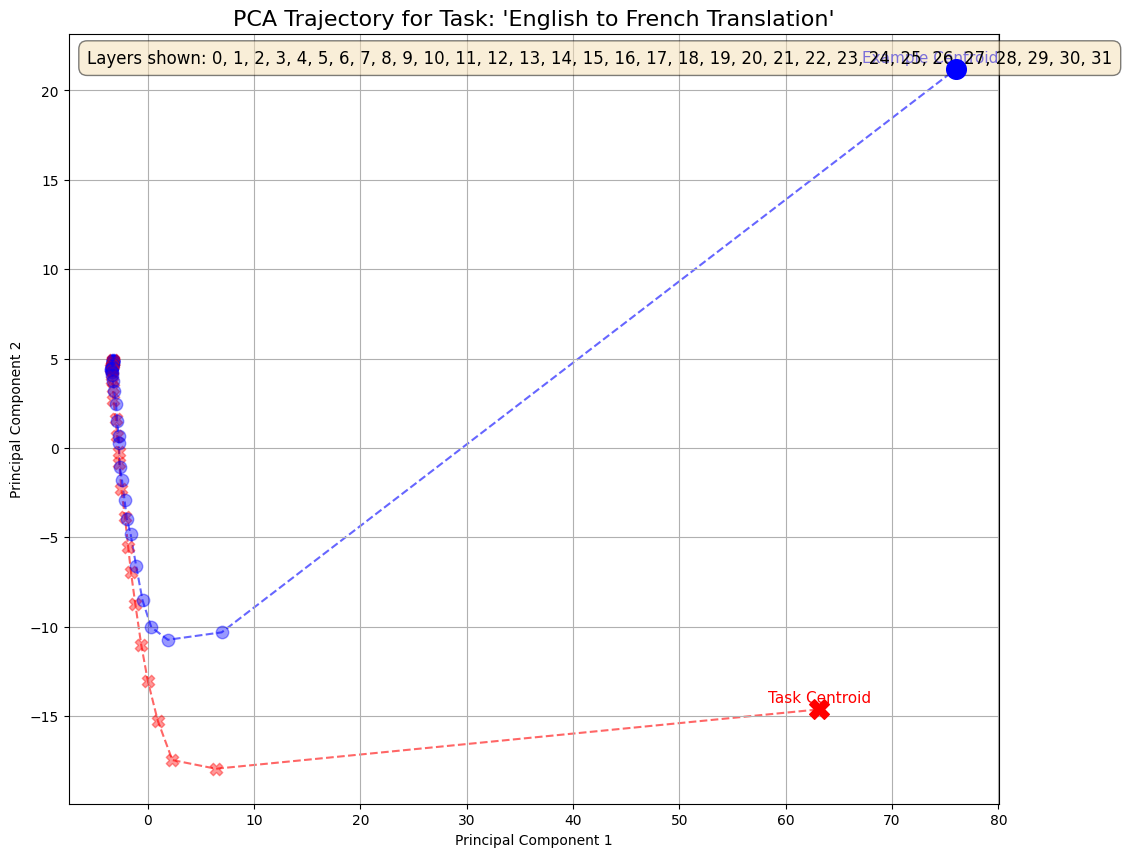

In [23]:
layers_to_show_pca = layer_indices

# Visualize the first task
task_to_visualize = processedTasks[0][0].name
visualize_pca_trajectory(
    hidden_states_by_task,
    task_name=task_to_visualize,
    layers_to_show=layers_to_show_pca,
    title=f"PCA Trajectory for Task: '{task_to_visualize}'",
)

# testing

In [39]:
from transformers import TextStreamer  # type: ignore

input_header = """<|start_header_id|>system<|end_header_id|>

Output **only** a JSON object with a single integer field “answer” (e.g. {"answer" : ...}).

<|eot_id|><|start_header_id|>human<|end_header_id|>

"""

task = "Given the pattern, what is the next answer?"

examples = """3 - 2 -> 5,
8 - 5 -> 13,
3 - 6 -> 9,
10 - 4 ->"""

input_footer = """

<|start_header_id|>assistant<|end_header_id|>

"""

task = [input_header, task, "<|eot_id|>", examples, input_footer]

test_input = ""
for x in task:
    test_input += x

print(test_input)
# test_input = '''<|start_header_id|>system<|end_header_id|>

# Cutting Knowledge Date: December 2023
# Today Date: 26 July 2024

# <|eot_id|><|start_header_id|>human<|end_header_id|>

# Given the pattern, what is the next answer? Give your final answer using /answer{}.<|eot_id|>
# 3 - 2 -> 5,
# 8 - 5 -> 13,
# 3 - 6 -> 9,
# 10 - 4 ->

# <|start_header_id|>assistant<|end_header_id|>


# '''
inputs = torch.tensor([tokenizer.encode(test_input)]).to("cuda")
# inputs
# ids = torch.tensor(tokenizer(inputs)['input_ids'])
# autoTokenizerIds = tokenizer.apply_chat_template(messages, tokenize = True, add_generation_prompt = True, return_tensors = "pt")
# print(autoTokenizerIds.shape)
# print("---")
# print(ids.shape)

# print(autoTokenizerIds)
# print("---")
# print(ids)

# print(autoTokenizerIds.tolist())
# print("---")
# print(ids.tolist())

# print(tokenizer.decode(autoTokenizerIds.tolist()[0]))
# print("---")
# print(tokenizer.decode(ids.tolist()))
text_streamer = TextStreamer(tokenizer)
_ = model.generate(
    input_ids=inputs, streamer=text_streamer, max_new_tokens=1024, use_cache=True
)

<|start_header_id|>system<|end_header_id|>

Output **only** a JSON object with a single integer field “answer” (e.g. {"answer" : ...}).

<|eot_id|><|start_header_id|>human<|end_header_id|>

Given the pattern, what is the next answer?<|eot_id|>3 - 2 -> 5,
8 - 5 -> 13,
3 - 6 -> 9,
10 - 4 ->

<|start_header_id|>assistant<|end_header_id|>


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Output **only** a JSON object with a single integer field “answer” (e.g. {"answer" :...}).

<|eot_id|><|start_header_id|>human<|end_header_id|>

Given the pattern, what is the next answer?<|eot_id|>3 - 2 -> 5,
8 - 5 -> 13,
3 - 6 -> 9,
10 - 4 ->

<|start_header_id|>assistant<|end_header_id|>

{"answer": 15}<|eot_id|>


In [ ]:
# test = tokenizer.encode(test_input)
# print(len(test))
# tokenizer.decode(test)
lengths = []
# recon_tokens = []   # reconstructed tokens list
for i, x in enumerate(task):
    section_tokens = tokenizer.encode(x)[
        0 if i == 0 else 1 :
    ]  # remove each begin_of_text token except first one
    # recon_tokens.extend(section_tokens)
    lengths.append(len(section_tokens))

indices = []
lower = 0
for upper in lengths:
    indices.append((lower, upper + lower))
    lower += upper

print(lengths)
print(indices)

# input_arr = [input_header, task, "<|eot_id|>", examples, input_footer]
task_indices = indices[1]
examples_indices = indices[3]

[30, 18, 1, 29, 5]
[(0, 30), (30, 48), (48, 49), (49, 78), (78, 83)]


In [ ]:
def pairwise_cosine_distance(vectors):
    """
    Calculates the mean pairwise cosine distance for a set of vectors.
    Args:
        vectors: A tensor of shape [N, D] where N is the number of vectors
                 and D is the embedding dimension.
    Returns:
        A single scalar value for the mean pairwise cosine distance.
    """
    if vectors.shape[0] < 2:
        return torch.tensor(0.0, device=vectors.device)

    # Normalize each vector to unit length
    normalized_vectors = torch.nn.functional.normalize(vectors, p=2, dim=1, eps=1e-12)

    # Compute the cosine similarity matrix by matrix-multiplying the normalized vectors
    # Resulting shape: [N, N]
    similarity_matrix = torch.matmul(normalized_vectors, normalized_vectors.T)

    # Cosine distance is 1 - similarity
    distance_matrix = 1 - similarity_matrix

    # We only want the unique pairwise distances, which are in the upper
    # triangle of the matrix (excluding the diagonal).
    # Get the indices of the upper triangle
    upper_triangle_indices = torch.triu_indices(
        distance_matrix.shape[0], distance_matrix.shape[1], offset=1
    )

    # Extract the values and calculate the mean
    pairwise_distances = distance_matrix[
        upper_triangle_indices[0], upper_triangle_indices[1]
    ]

    return torch.mean(pairwise_distances)


rho_d_by_layer = []
d_r_by_layer = []

for i in range(num_layers):
    # print(f"layer {i}")
    layer_hidden_states = all_layer_outputs[i]

    lower, upper = task_indices
    task_vecs = layer_hidden_states[0, lower:upper, :]
    lower, upper = examples_indices
    example_vecs = layer_hidden_states[0, lower:upper, :]
    # print(task_vecs.shape)
    # print(example_vecs.shape)
    # Calculate Pattern Density (rho_d)
    if len(example_vecs) > 1:
        # example_vecs = example_vecs.to(torch.float32)
        mean_cos_dist = pairwise_cosine_distance(example_vecs)
        rho_d = 1 / (mean_cos_dist + 1e-6)
    else:
        rho_d = 0
    rho_d_by_layer.append(rho_d.item())

    # Calculate Representational Mismatch (d_r)
    pattern_centroid = torch.mean(example_vecs, dim=0)
    # print(pattern_centroid.shape)
    # print()
    task_centroid = torch.mean(task_vecs, dim=0)
    d_r = 1 - torch.nn.functional.cosine_similarity(
        task_centroid, pattern_centroid, dim=0
    )
    d_r_by_layer.append(d_r.item())

In [36]:
print(len(rho_d_by_layer))
print(len(d_r_by_layer))

32
32


/tmp/ipykernel_3945243/1999852951.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper right')
/tmp/ipykernel_3945243/1999852951.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper left')


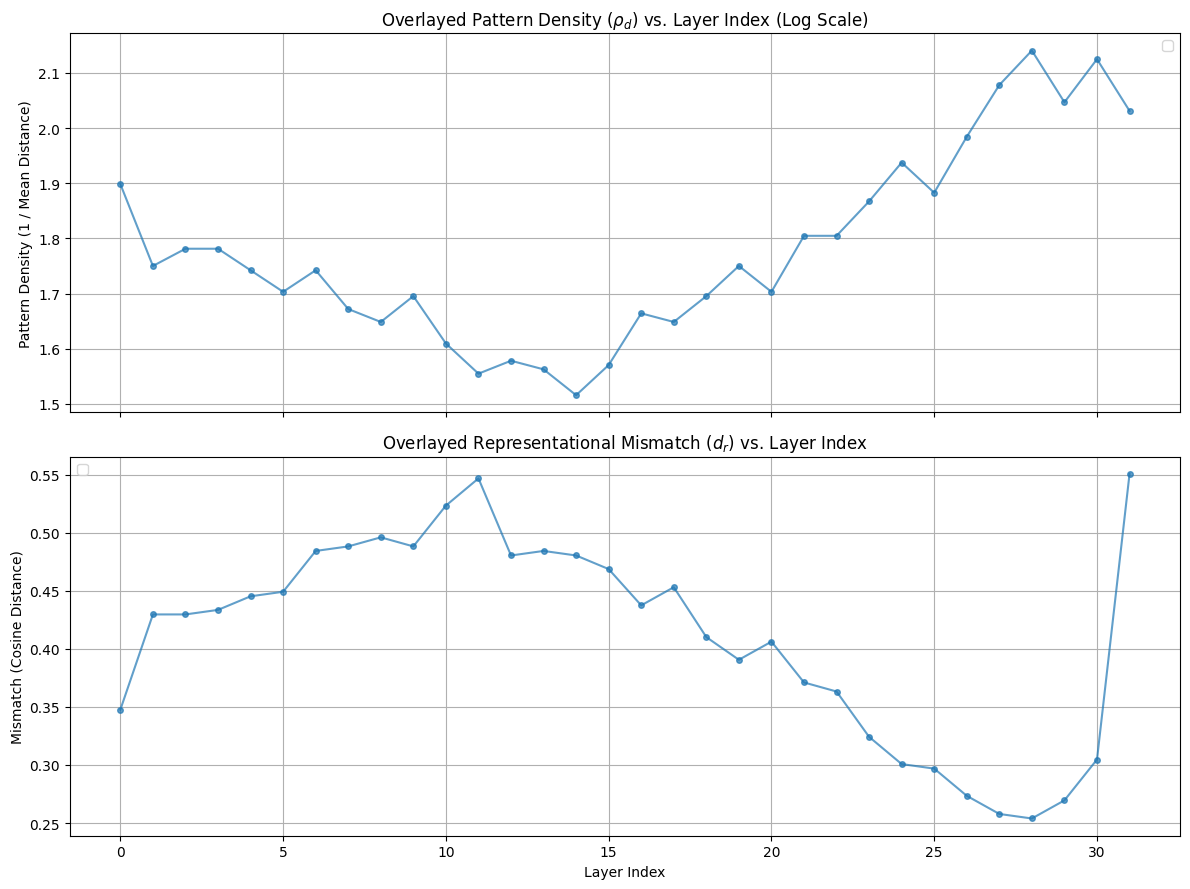

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Get the data for this task
layer_indices = list(range(num_layers))
rho_d_values = rho_d_by_layer
d_r_values = d_r_by_layer


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

# Plot Pattern Density for this task
ax1.plot(
    layer_indices, rho_d_values, marker="o", markersize=4, linestyle="-", alpha=0.7
)

# Plot Representational Mismatch for this task
ax2.plot(layer_indices, d_r_values, marker="o", markersize=4, linestyle="-", alpha=0.7)

# --- Configure the plots ---

# Configure Plot 1: Pattern Density
ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index")
ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
ax1.legend(loc="upper right")
ax1.grid(True)
# Set a log scale for better visibility if early values are very high
# ax1.set_yscale('log')
ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index (Log Scale)")


# Configure Plot 2: Representational Mismatch
ax2.set_title("Overlayed Representational Mismatch ($d_r$) vs. Layer Index")
ax2.set_ylabel("Mismatch (Cosine Distance)")
ax2.set_xlabel("Layer Index")
ax2.legend(loc="upper left")
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# all_rho_d = np.array([res["rho_d"] for res in all_task_results.values()])
# all_d_r = np.array([res["d_r"] for res in all_task_results.values()])

# Calculate mean and standard deviation across tasks for each layer
# mean_rho_d = np.mean(all_rho_d, axis=0)
# std_rho_d = np.std(all_rho_d, axis=0)

# mean_d_r = np.mean(all_d_r, axis=0)
# std_d_r = np.std(all_d_r, axis=0)

# # Create the plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
# layer_indices = list(range(num_layers))

# print(len(layer_indices))
# print(len(mean_rho_d))
# # Plot Aggregated Pattern Density
# ax1.plot(layer_indices, mean_rho_d, marker='o', linestyle='-', label='Mean')
# ax1.fill_between(layer_indices, mean_rho_d - std_rho_d, mean_rho_d + std_rho_d, alpha=0.2, label='Std. Dev.')
# ax1.set_title('Aggregated Pattern Density ($\\rho_d$) vs. Layer Index (Across All Tasks)')
# ax1.set_ylabel('Pattern Density (1 / Mean Distance)')
# ax1.legend()
# ax1.grid(True)

# # Plot Aggregated Representational Mismatch
# ax2.plot(layer_indices, mean_d_r, marker='o', linestyle='-', color='r', label='Mean')
# ax2.fill_between(layer_indices, mean_d_r - std_d_r, mean_d_r + std_d_r, color='r', alpha=0.2, label='Std. Dev.')
# ax2.set_title('Aggregated Representational Mismatch ($d_r$) vs. Layer Index (Across All Tasks)')
# ax2.set_ylabel('Mismatch (Cosine Distance)')
# ax2.set_xlabel('Layer Index')
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# print("\nGenerating overlayed plots for all tasks...")

# # Create the plot figure
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# layer_indices = list(range(num_layers))

# # Use a colormap to get distinct colors for each task
# colors = plt.cm.viridis(np.linspace(0, 1, len(all_task_results)))

# # Loop through each stored task result and plot it
# for i, (task_name, results) in enumerate(all_task_results.items()):
#     # Get the data for this task
#     rho_d_values = results["rho_d"]
#     d_r_values = results["d_r"]

#     # Plot Pattern Density for this task
#     ax1.plot(layer_indices, rho_d_values, marker='o', markersize=4, linestyle='-', alpha=0.7, color=colors[i], label=task_name)

#     # Plot Representational Mismatch for this task
#     ax2.plot(layer_indices, d_r_values, marker='o', markersize=4, linestyle='-', alpha=0.7, color=colors[i], label=task_name)

# # --- Configure the plots ---

# # Configure Plot 1: Pattern Density
# ax1.set_title('Overlayed Pattern Density ($\\rho_d$) vs. Layer Index')
# ax1.set_ylabel('Pattern Density (1 / Mean Distance)')
# ax1.legend(loc='upper right')
# ax1.grid(True)
# # Set a log scale for better visibility if early values are very high
# ax1.set_yscale('log')
# ax1.set_title('Overlayed Pattern Density ($\\rho_d$) vs. Layer Index (Log Scale)')


# # Configure Plot 2: Representational Mismatch
# ax2.set_title('Overlayed Representational Mismatch ($d_r$) vs. Layer Index')
# ax2.set_ylabel('Mismatch (Cosine Distance)')
# ax2.set_xlabel('Layer Index')
# ax2.legend(loc='upper left')
# ax2.grid(True)

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# --- Step 3: Iterate Through Tasks and Collect Data ---
for task in task_suite:
    name = task["name"]
    print(f"\nProcessing task: {name}")

    # Clear previous run's data
    all_layer_outputs.clear()

    # Prepare inputs for the current task
    text_to_process = [task["instruction"]] + task["examples"]
    print(text_to_process)
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token
    inputs = tokenizer(text_to_process, padding=True, return_tensors="pt").to(device)

    # Run the model to trigger all hooks for this task
    with torch.no_grad():
        # outputs = model.generate(**inputs, max_new_tokens=50, return_dict_in_generate=True, output_scores=True)
        out = model(**inputs)

    # input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]

    # generated_tokens = outputs.sequences[:, input_length:]

    # transition_scores = model.compute_transition_scores(
    # 	outputs.sequences, outputs.scores, normalize_logits=True
    # )

    # for tok, score in zip(generated_tokens[0].to('cpu'), transition_scores[0].to('cpu')):

    # 	# | token | token string | log probability | probability
    #     print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} \t| {np.exp(score.numpy()):.2%}")

    logits = out.logits
    print(
        f"Shape of logits: {logits.shape}"
    )  # e.g., torch.Size([1, num_tokens, vocab_size])

    token_logits = logits[0, :, :]  # Get the logits all tokens in the sequence
    print(f"Shape of token logits: {token_logits.shape}")

    # --- decoding all logits ---
    for i, ls in enumerate(token_logits.topk(10).indices):
        lower = torch.argmax(ls)
        print(f"Token ID: {lower.item()} - Token: {tokenizer.decode(lower)}")

    next_token_logits = logits[0, -1, :]
    print(f"Shape of logits for the next token: {next_token_logits.shape}")

    # --- Step 2: Get the Token ID for all possible Next Tokens
    for lower in next_token_logits.topk(10).indices:
        print(f"Token ID: {lower.item()} - Token: {tokenizer.decode(lower)}")

    # --- Step 2 (Method A): Greedy Decoding ---
    predicted_token_id_greedy = torch.argmax(next_token_logits)
    print(f"\nGreedy Method:")
    print(f"  Predicted Token ID: {predicted_token_id_greedy.item()}")

    # Process the captured data for this task
    rho_d_by_layer = []
    d_r_by_layer = []

    for i in range(num_layers):
        layer_hidden_states = all_layer_outputs[i]

        # Use the representation of the *last token* as the summary for each sentence
        task_vecs = layer_hidden_states[0, -1, :]
        example_vecs = layer_hidden_states[1:, -1, :]

        # Calculate Pattern Density (rho_d)
        if len(example_vecs) > 1:
            pairwise_distances = torch.pdist(example_vecs)
            rho_d = 1 / (torch.mean(pairwise_distances) + 1e-6)
        else:
            rho_d = 0
        rho_d_by_layer.append(rho_d.item())

        # Calculate Representational Mismatch (d_r)
        pattern_centroid = torch.mean(example_vecs, dim=0)
        d_r = 1 - torch.nn.functional.cosine_similarity(
            task_vecs, pattern_centroid, dim=0
        )
        d_r_by_layer.append(d_r.item())

    # Store the results for this task
    all_task_results[name] = {"rho_d": rho_d_by_layer, "d_r": d_r_by_layer}

# --- Step 4: Clean Up Hooks ---
for handle in hook_handles:
    handle.remove()
print(f"\nRemoved all {len(hook_handles)} hooks. Data collection complete.")


Processing task: English to French Translation
['Translate the following from English to French.', 'the cat is black -> le chat est noir', 'the dog is white -> le chien est blanc', "I love science -> j'aime la science", 'are you my friend? ->']
Shape of logits: torch.Size([5, 11, 128256])
Shape of token logits: torch.Size([11, 128256])
Token ID: 0 - Token: !
Token ID: 0 - Token: !
Token ID: 5 - Token: &
Token ID: 6 - Token: '
Token ID: 5 - Token: &
Token ID: 0 - Token: !
Token ID: 7 - Token: (
Token ID: 8 - Token: )
Token ID: 4 - Token: %
Token ID: 9 - Token: *
Token ID: 3 - Token: $
Shape of logits for the next token: torch.Size([128256])
Token ID: 220 - Token:  
Token ID: 578 - Token:  The
Token ID: 320 - Token:  (
Token ID: 5560 - Token:  Use
Token ID: 5112 - Token:  Then
Token ID: 358 - Token:  I
Token ID: 362 - Token:  A
Token ID: 5321 - Token:  Please
Token ID: 1442 - Token:  If
Token ID: 1472 - Token:  You

Greedy Method:
  Predicted Token ID: 220

Processing task: Country to C

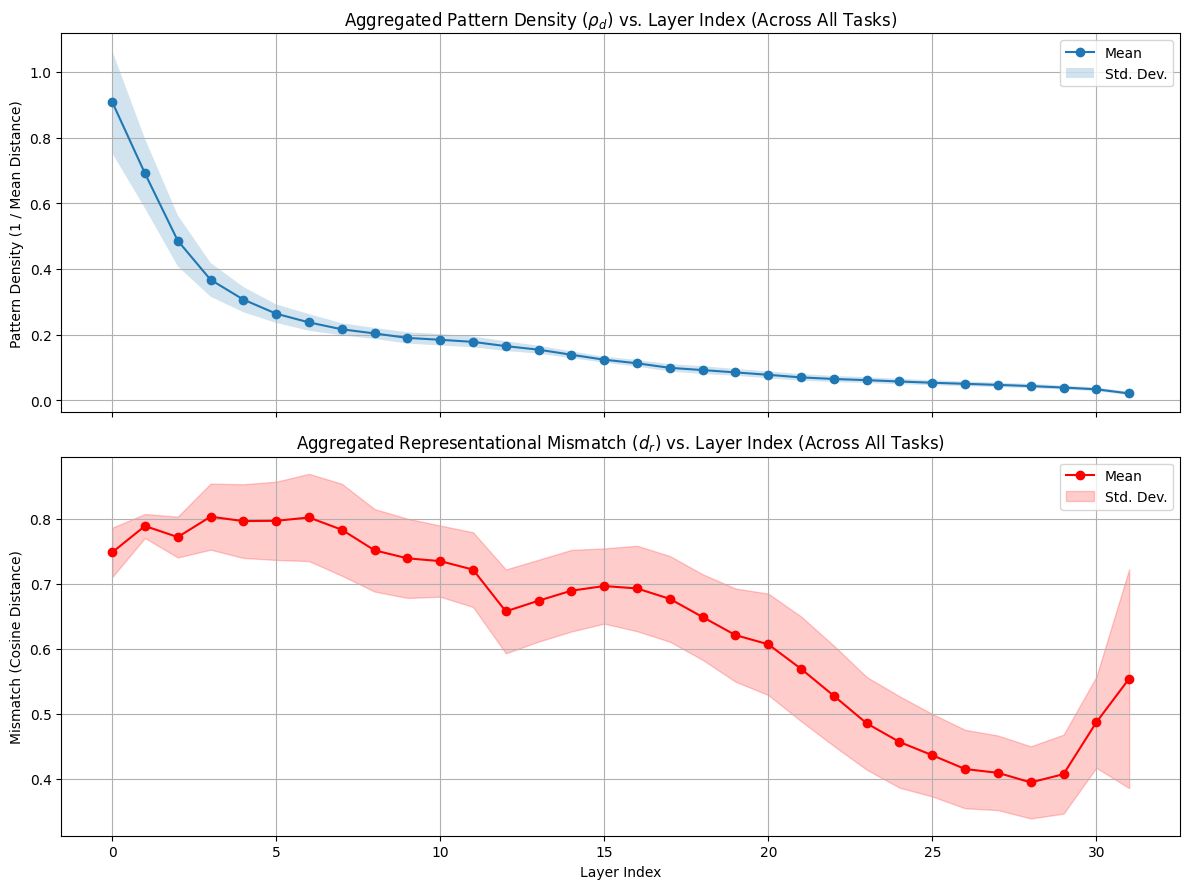


Generating overlayed plots for all tasks...


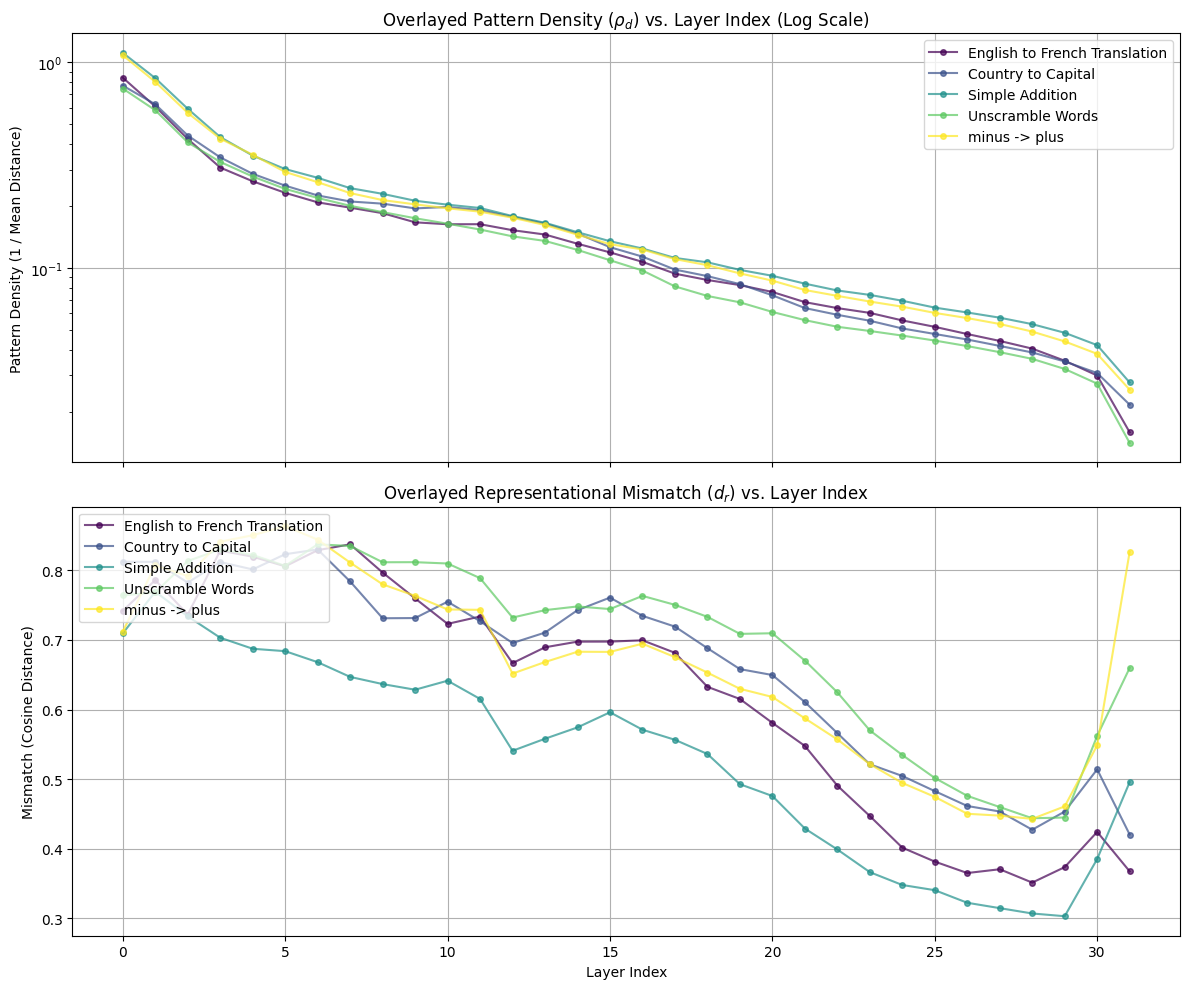

In [ ]:
# --- Step 5: Aggregate and Visualize the Results ---
# Aggregate all results into numpy arrays for easy calculation
all_rho_d = np.array([res["rho_d"] for res in all_task_results.values()])
all_d_r = np.array([res["d_r"] for res in all_task_results.values()])

# Calculate mean and standard deviation across tasks for each layer
mean_rho_d = np.mean(all_rho_d, axis=0)
std_rho_d = np.std(all_rho_d, axis=0)

mean_d_r = np.mean(all_d_r, axis=0)
std_d_r = np.std(all_d_r, axis=0)

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
layer_indices = list(range(num_layers))

# Plot Aggregated Pattern Density
ax1.plot(layer_indices, mean_rho_d, marker="o", linestyle="-", label="Mean")
ax1.fill_between(
    layer_indices,
    mean_rho_d - std_rho_d,
    mean_rho_d + std_rho_d,
    alpha=0.2,
    label="Std. Dev.",
)
ax1.set_title(
    "Aggregated Pattern Density ($\\rho_d$) vs. Layer Index (Across All Tasks)"
)
ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
ax1.legend()
ax1.grid(True)

# Plot Aggregated Representational Mismatch
ax2.plot(layer_indices, mean_d_r, marker="o", linestyle="-", color="r", label="Mean")
ax2.fill_between(
    layer_indices,
    mean_d_r - std_d_r,
    mean_d_r + std_d_r,
    color="r",
    alpha=0.2,
    label="Std. Dev.",
)
ax2.set_title(
    "Aggregated Representational Mismatch ($d_r$) vs. Layer Index (Across All Tasks)"
)
ax2.set_ylabel("Mismatch (Cosine Distance)")
ax2.set_xlabel("Layer Index")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nGenerating overlayed plots for all tasks...")

# Create the plot figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
layer_indices = list(range(num_layers))

# Use a colormap to get distinct colors for each task
colors = plt.cm.viridis(np.linspace(0, 1, len(all_task_results)))

# Loop through each stored task result and plot it
for i, (name, results) in enumerate(all_task_results.items()):
    # Get the data for this task
    rho_d_values = results["rho_d"]
    d_r_values = results["d_r"]

    # Plot Pattern Density for this task
    ax1.plot(
        layer_indices,
        rho_d_values,
        marker="o",
        markersize=4,
        linestyle="-",
        alpha=0.7,
        color=colors[i],
        label=name,
    )

    # Plot Representational Mismatch for this task
    ax2.plot(
        layer_indices,
        d_r_values,
        marker="o",
        markersize=4,
        linestyle="-",
        alpha=0.7,
        color=colors[i],
        label=name,
    )

# --- Configure the plots ---

# Configure Plot 1: Pattern Density
ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index")
ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
ax1.legend(loc="upper right")
ax1.grid(True)
# Set a log scale for better visibility if early values are very high
ax1.set_yscale("log")
ax1.set_title("Overlayed Pattern Density ($\\rho_d$) vs. Layer Index (Log Scale)")


# Configure Plot 2: Representational Mismatch
ax2.set_title("Overlayed Representational Mismatch ($d_r$) vs. Layer Index")
ax2.set_ylabel("Mismatch (Cosine Distance)")
ax2.set_xlabel("Layer Index")
ax2.legend(loc="upper left")
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Old

In [ ]:
# A dictionary to store the output we want to capture
all_layer_outputs = {}


# Define a hook function
def get_layer_output_hook(layer_idx):
    def hook(module, input, output):
        # In PyTorch hooks, 'output' is what you want.
        # We detach it from the computation graph to save memory.
        all_layer_outputs[layer_idx] = output[0].detach()

    return hook


hook_handles = []
num_layers = len(model.model.layers)  # Should be 32 for your model

for i in range(num_layers):
    target_layer = model.model.layers[i]
    handle = target_layer.register_forward_hook(get_layer_output_hook(i))
    hook_handles.append(handle)

print(f"Attached {len(hook_handles)} hooks to layers 0 through {num_layers - 1}.")

task_instruction = "Identify the pattern"
anchor_examples = ["3 - 2 = 5", "8 - 5 = 13", "3 - 6 = 9"]
# Note: For a real experiment, you'd process each part of the anchor example separately
# to get the vector for 'cat', 'chat', 'dog', 'chien', etc. This is a simplification.

# For this example, let's just encode the whole anchor set at once
# In a real implementation, you'd get the specific token embeddings you need
text_to_process = [task_instruction] + anchor_examples
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token
inputs = tokenizer(text_to_process, padding=True, return_tensors="pt").to(device)

print("\nRunning a single forward pass to trigger all hooks...")
with torch.no_grad():
    model(**inputs)
print("Forward pass complete.")

# --- Step 4: Clean Up the Hooks Immediately ---
for handle in hook_handles:
    handle.remove()
print(f"Removed all {len(hook_handles)} hooks.")

# --- Step 5: Process the Captured Data Layer by Layer ---
rho_d_by_layer = []
d_r_by_layer = []

print("\nCalculating rho_d and d_r for each layer...")
for i in range(num_layers):
    # Get the hidden states for this layer [batch_size, num_tokens, hidden_size]
    layer_hidden_states = all_layer_outputs[i]

    # Separate the representations
    # First item in batch is the task, the rest are examples
    task_vecs = layer_hidden_states[0, -1, :]  # Vector for last token of instruction
    example_vecs = layer_hidden_states[
        1:, -1, :
    ]  # Vectors for last token of each example

    # Calculate Pattern Density (rho_d)
    # Using torch.pdist for efficient pairwise distance calculation
    if len(example_vecs) > 1:
        pairwise_distances = torch.pdist(example_vecs)
        mean_dist = torch.mean(pairwise_distances)
        rho_d = 1 / (mean_dist + 1e-6)  # Add epsilon for stability
    else:
        rho_d = 0  # Not defined for a single example
    rho_d_by_layer.append(rho_d.item())

    # Calculate Representational Mismatch (d_r)
    pattern_centroid = torch.mean(example_vecs, dim=0)
    # Cosine similarity is dot(a,b) / (norm(a)*norm(b))
    cos_sim = torch.nn.functional.cosine_similarity(task_vecs, pattern_centroid, dim=0)
    d_r = 1 - cos_sim
    d_r_by_layer.append(d_r.item())

print("Calculations complete.")

# --- Step 6: Visualize the Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
layer_indices = list(range(num_layers))

# Plot Pattern Density
ax1.plot(layer_indices, rho_d_by_layer, marker="o", linestyle="-")
ax1.set_title("Pattern Density ($\\rho_d$) vs. Layer Index")
ax1.set_ylabel("Pattern Density (1 / Mean Distance)")
ax1.grid(True)

# Plot Representational Mismatch
ax2.plot(layer_indices, d_r_by_layer, marker="o", linestyle="-", color="r")
ax2.set_title("Representational Mismatch ($d_r$) vs. Layer Index")
ax2.set_ylabel("Mismatch (Cosine Distance)")
ax2.set_xlabel("Layer Index")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# # Now, run a forward pass with your text
# # text = "The capital of France is:"
# text = "2 - 3 = 5\n7 - 4 = 11\n15 - 8 = 23\n 8 + 2 = 6. What is the pattern?\n The pattern is"
# inputs = tokenizer(text, return_tensors="pt").to(device)
# # if torch.cuda.is_available():
# # 	inputs = {k: v.to(device) for k, v in inputs.items()}

# outputs = model.generate(**inputs, max_new_tokens=50, return_dict_in_generate=True, output_scores=True)

# input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]

# generated_tokens = outputs.sequences[:, input_length:]

# transition_scores = model.compute_transition_scores(

#     outputs.sequences, outputs.scores, normalize_logits=True

# )

# for tok, score in zip(generated_tokens[0].to('cpu'), transition_scores[0].to('cpu')):

#     # | token | token string | log probability | probability
#     print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} \t| {np.exp(score.numpy()):.2%}")

# # with torch.no_grad():
# #     out = model(**inputs)

# # The output is now in our dictionary
# # This is the vector you need for your encode() function
# encoded_vector = captured_outputs['hidden_state']

# # remove the hook to avoid memory leaks
# hook_handle.remove()

In [ ]:
# captured_outputs

In [ ]:
# --- Step 1: Isolate the Logits for the NEXT Token ---
# The logits tensor has shape [batch_size, sequence_length, vocab_size]

# logits = out.logits
# print(f"Shape of logits: {logits.shape}")  # e.g., torch.Size([1, num_tokens, vocab_size])

# token_logits = logits[0, :, :]  # Get the logits all tokens in the sequence
# print(f"Shape of token logits: {token_logits.shape}")

# # --- decoding all logits ---
# for i, ls in enumerate(token_logits.topk(10).indices):
#     l = torch.argmax(ls)
#     print(f"Token ID: {l.item()} - Token: {tokenizer.decode(l)}")


# next_token_logits = logits[0, -1, :]
# print(f"Shape of logits for the next token: {next_token_logits.shape}")


# --- Step 2: Get the Token ID for all possible Next Tokens
# for l in next_token_logits.topk(10).indices:
# 	print(f"Token ID: {l.item()} - Token: {tokenizer.decode(l)}")


# # --- Step 2 (Method A): Greedy Decoding ---
# predicted_token_id_greedy = torch.argmax(next_token_logits)
# print(f"\nGreedy Method:")
# print(f"  Predicted Token ID: {predicted_token_id_greedy.item()}")

# # --- Step 3 (for Greedy): Decode the Token ID ---
# predicted_text_greedy = tokenizer.decode(predicted_token_id_greedy)
# print(f"  Decoded Text: '{predicted_text_greedy}'")
# print(f"  Full sentence: {text}{predicted_text_greedy}")

# # SAMPLING

# # --- Step 2 (Method B): Sampling ---
# # Apply softmax to convert logits to probabilities
# probabilities = torch.softmax(next_token_logits, dim=-1)
# # Sample a token from the distribution
# predicted_token_id_sampled = torch.multinomial(probabilities, num_samples=1)
# print(f"\nSampling Method:")
# print(f"  Predicted Token ID: {predicted_token_id_sampled.item()}")

# # --- Step 3 (for Sampling): Decode the Token ID ---
# predicted_text_sampled = tokenizer.decode(predicted_token_id_sampled.squeeze())
# print(f"  Decoded Text: '{predicted_text_sampled}'")
# print(f"  Full sentence: {text}{predicted_text_sampled}")


# # --- BONUS: The Easy Way with .generate() ---
# # The .generate() method does all of the above (and more) in a loop for you!
# print("\n--- Using the built-in .generate() method ---")
# # `.generate()` automatically handles the autoregressive loop, sampling, etc.
# # max_new_tokens controls how many new tokens to generate.
# generated_ids = model.generate(**inputs, max_new_tokens=5)
# generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
# print(generated_text[0])

# Starter Code

In [ ]:
import numpy as np


def get_embedding(text: str, layer_index: int, pool: str = "mean"):
    """
    Encode text and return embedding from specified layer.
    - layer_index: index into hidden_states; 0 is embedding output,
    1 is after first Transformer block, ..., model.config.num_hidden_layers for last
    .
    - pool: "mean" or "first".
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
        hidden_states = out.hidden_states
    hs = hidden_states[layer_index]  # (1, seq_len, hidden_size)
    hs = hs.squeeze(0)  # (seq_len, hidden_size)
    if pool == "mean":
        emb = hs.mean(dim=0)
    elif pool == "first":
        emb = hs[0]
    else:
        raise ValueError(f"Unknown pool type: {pool}")
    return emb.cpu().numpy()

In [ ]:
from sklearn.neighbors import NearestNeighbors


def compute_rho_knn(pattern_embeddings: np.ndarray, k: int = 5, eps: float = 1e-8):
    """
        pattern_embeddings: (n_tasks, dim)
    Returns: rho array of shape (n_tasks,)
    """
    nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm="auto").fit(pattern_embeddings)
    distances, _ = nbrs.kneighbors(pattern_embeddings)
    dists = distances[:, 1 : k + 1]  # exclude self
    avg = dists.mean(axis=1)
    rho = 1.0 / (avg + eps)
    return rho